# Week 4

In [1]:
# Own Libraries
from utils.plotting import plot_image_and_similar
from utils.data import DataManager
from utils.metrics import prec_recall, iou_score, f1_dice
from utils.denoising import denoise_images
from utils.similarity import Similarity
from utils.image_processing import image_to_windows, get_3d_norm_histogram, calculate_histograms,text_removal
from utils.image_processing import calculate_histograms, text_removal, calculate_hog, calculate_lbp, calculate_orb, calculate_sift
from utils.segbackground import NMS, background_crop,iou_score
# 3rd Party Libraries
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import estimate_sigma
from scipy.ndimage import gaussian_filter
from typing import Tuple, List
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import ml_metrics as metrics
import cv2
import os
import pickle
import math

In [2]:
def readimg (path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def estimate_noise(img):
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

# Load Data

In [3]:
# Load Data
data_manager = DataManager()
db, db_files = data_manager.load_data(folder = "./data/BBDD/", extension = ".jpg", desc = "Loading BBDD Data...")

qsd1_w4, qsd1_w4_files = data_manager.load_data(folder = "./data/qsd1_w4/", extension = ".jpg", desc = "Loading qsd1_w4 Data...")
qst1_w4, qst1_w4_files = data_manager.load_data(folder = "./data/qst1_w4/", extension = ".jpg", desc = "Loading qst1_w4 Data...")

Loading qsd1_w4 Data...:  53%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 16/30 [00:00<00:00, 131.03it/s]

./data/BBDD/ read: 287 images


Loading qst1_w4 Data...:   0%|                                                                                                                                                                                                         | 0/50 [00:00<?, ?it/s]

./data/qsd1_w4/ read: 30 images


Loading qst1_w4 Data...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 108.36it/s]


./data/qst1_w4/ read: 50 images


This week we use mainly:
- QSD1-W4 (30) / QST1-W4 (50)  pictures with background, with overlapping text (name of painter), one, two or three paintings per image, some paintings with noise, some paintings with changes in color, some paintings not in database

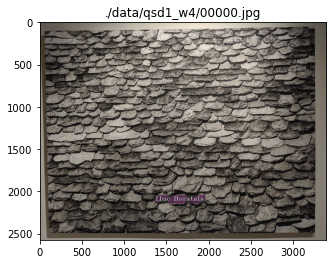

In [4]:
for img, filename in zip(qsd1_w4[:3], qsd1_w4_files[:3]):
    plt.imshow(img)
    plt.title(filename)
    break # 

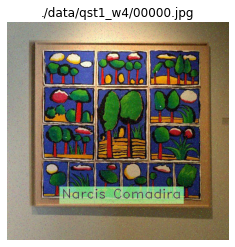

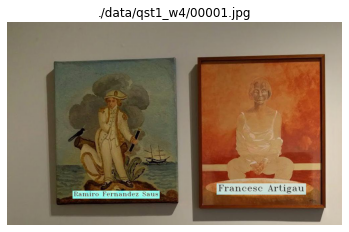

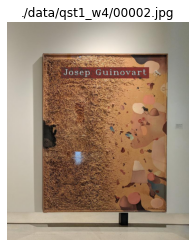

In [5]:
for img, filename in zip(qst1_w4[:3], qst1_w4_files[:3]):
    plt.imshow(img)
    plt.title(filename)
    plt.axis('off')
    plt.show()

## Preprocessing: Noise Reduction

In [6]:
DENOISE = False

if DENOISE: 
    qsd1_w4 = denoise_images(qsd1_w4, method='nlmeans', ksize=(5,5))
    qst1_w4 = denoise_images(qst1_w4, method='nlmeans', ksize=(5,5))

## Step 1) Crop, background removal and obtain the pictures.

In [7]:
DO_BKGCROP = True

In [8]:
def background_crop (files, gt_masks= True, save_masks = False, plot_results=True, plot_rect=False):
    
    SCORES = []
    PREDICTIONS = {}
    RESULT = []
    FILENAMES = []

    for file in files:

        base = readimg (file)
        if gt_masks:
            gt_mask = readimg (file.replace('.jpg', '.png'))

        base_rgb = base.copy()
        rgb = base.copy()
        
        base = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
        gray = base.copy()

        # Performing OTSU threshold
        
        _, base = cv2.threshold(base, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
        kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
        base = cv2.filter2D(base, -1, kernel)
        
        if base.shape[1]/base.shape[0] > 1.55: 
            # landscape images = multiple pictures
            _, base_inv = cv2.threshold(base, 0, 255, cv2.THRESH_OTSU)
            base_inv = cv2.filter2D(base_inv, -1, kernel)
            #print (base.shape[1]/base.shape[0], base.shape)            

        # Morphology mask
        mask = base
        
        # opening 1) correct noise
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        
        # closing 1) get shapes
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)), iterations = 1)
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11)), iterations = 1)
        # closing 2) get shapes
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5)), iterations = 1)
        
        # opening -> closing define better edges
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations = 1)
        
        mask = cv2.filter2D(mask, -1, kernel)
        mask = ((mask - 255)*(-1)).astype(np.uint8)
        
        #if base.shape[1]/base.shape[0] > 1.55: 
            #print (mask.dtype, mask.min(), mask.max())
            #mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13)), iterations = 1)
            #mask = cv2.erode(mask, cv2.getStructuringElement(cv2.MORPH_RECT, (13, 13)), iterations = 1)
        
        # Finding contours
        
        contours_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours_base, _ = cv2.findContours(base, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contours = contours_mask + contours_base
        assert len(contours) == len(contours_base)+len(contours_mask)
            
        if base.shape[1]/base.shape[0] > 1.55: 
            contours_base_inv, _ = cv2.findContours(base_inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            contours = contours_mask + contours_base + contours_base_inv
           
        boxes = []
        areas = []
        
        for cnt in contours:
            
            x, y, w, h = cv2.boundingRect(cnt)
            cropped = base_rgb[y:y + h, x:x + w]
            area_cropped = cropped.shape[0] * cropped.shape[1]
            
            cond1 = (cropped.shape[1] >= int(rgb.shape[1]*0.9)) and (cropped.shape[0] <= int(rgb.shape[0]*0.25))
            cond2 = (base.shape[1]/base.shape[0] > 1.55)
            cond3 = cond2 and ((cropped.shape[0]*cropped.shape[1]) >= 0.9 * (rgb.shape[0]*rgb.shape[1]))
            
            if (area_cropped <= 200*200) or (cropped.shape[0] < 200) or (cropped.shape[1] < 200) or cond3: 
                continue
            elif cond1 and not(cond2):
                aux_box = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
                cropped = base_rgb[0:0 + rgb.shape[1], 0:0 + rgb.shape[0]]
                area_cropped = cropped.shape[0] * cropped.shape[1]
            
                boxes.append(aux_box)
                areas.append((area_cropped, aux_box))
                
            else: 
                boxes.append((x, y, x + w, y + h))
                areas.append((area_cropped, (x, y, x + w, y + h)))
                #areas[area_cropped] = (x, y, x + w, y + h)
        
        
        if not(cond2): 
            boxes = NMS(np.array(boxes), overlapThresh = 0.5)

        # Produce mask
        morph_mask = mask.copy()
        mask = np.zeros(base_rgb.shape)
        
        contours_detect = len(boxes)
        #print ('contours detected:', len(boxes))
        
        if contours_detect > 20:
            # outlier due to weird texture images
            contours_detect = 1
            x, y, x2, y2 = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            if plot_rect:
                rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                
            PREDICTIONS[file] = boxes[0]
            RESULT.append(cropped)
            FILENAMES.append(file)
            
        elif contours_detect > 1:
            # 3 biggest boxes
            
            # remove possible duplicates in the lists
            areas = list(set(areas))
            #assert len(areas) == contours_detect
            #print (areas)
            #print ([x[0] for x in areas])
            #big = areas.sort(key=lambda x:x[0])
            areas = sorted(areas, key=lambda tup: tup[0], reverse=True)
            
            if len(areas) == 1:
                box1   = areas[0][1]
                nboxes = [box1]
            else:
                box1   = areas[0][1]
                box2   = areas[1][1]
                nboxes = [box1, box2]
            
            contours_detect = len(nboxes)
            
            PREDICTIONS[file] = nboxes
            for box in nboxes:
                x, y, x2, y2 = box
                cropped = base_rgb[y:y2, x:x2]
                mask [y:y2, x:x2] = 1
                if plot_rect:
                    rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                    
                #plt.imshow(cropped)
                #plt.axis('off')
                #plt.show()
                RESULT.append(cropped)
                FILENAMES.append(file)
                
        elif contours_detect == 1:
            
            x, y, x2, y2 = boxes[0]
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            #print (x, y, x2, y2)
            if plot_rect:
                rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                
            PREDICTIONS[file] = boxes[0]
            RESULT.append(cropped)
            FILENAMES.append(file)
            #plt.imshow(rect)
            #plt.axis('off')
            #plt.show()
            #plt.imshow(cropped)
            #plt.axis('off')
            #plt.show()
            
        else:
            contours_detect = 1
            x, y, x2, y2 = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
            cropped = base_rgb[y:y2, x:x2]
            mask [y:y2, x:x2] = 1
            #print (x, y, x2, y2)
            if plot_rect:
                rect = cv2.rectangle(base_rgb, (x, y), (x2, y2), (0, 255, 0), 10)
                
            PREDICTIONS[file] = (0, 0, 0 + rgb.shape[1], 0 + rgb.shape[0])
            RESULT.append(cropped)
            FILENAMES.append(file)
            
            
        mask = mask.astype(np.uint8) * 255

        try: 
            mask_iou = iou_score(gt_mask, mask)
        except:
            mask_iou = 0.75
        
        SCORES.append(mask_iou)
        
        if plot_results:
            
            assert contours_detect <= 2
 
            f, axarr = plt.subplots(1,6, figsize=(15,15))
            axarr[0].imshow(rgb)
            axarr[0].title.set_text("RGB")
            axarr[0].axis('off')
            axarr[1].imshow(base, cmap="gray")
            axarr[1].title.set_text("Otsu's Binarized")
            axarr[1].axis('off')
            axarr[2].imshow(morph_mask, cmap="gray")
            axarr[2].title.set_text(f"Morphology Mask {contours_detect}")
            axarr[2].axis('off')
            axarr[3].imshow(mask, cmap="gray")
            axarr[3].title.set_text(f"Final Mask {np.round(mask_iou,2)} iou")
            axarr[3].axis('off')
            if gt_masks: 
                axarr[4].imshow(gt_mask, cmap="gray")
            else:
                axarr[4].imshow(mask, cmap="gray")
            axarr[4].title.set_text("GT Mask")
            axarr[4].axis('off')
            axarr[5].imshow(base_rgb)
            axarr[5].title.set_text("RGB")
            axarr[5].axis('off')
            plt.show()
    
    if gt_masks:
        print ('\n>> Mean IOU Score: ', np.mean(SCORES))
        
    assert len(RESULT) == len(FILENAMES)
    return RESULT, FILENAMES

In [9]:
new_qsd1_w4, new_qsd1_w4_files = background_crop (files= qsd1_w4_files, gt_masks= True,  save_masks = False, plot_results=False, plot_rect=False)
new_qst1_w4, new_qst1_w4_files = background_crop (files= qst1_w4_files, gt_masks= False,  save_masks = False, plot_results=False, plot_rect=False)


>> Mean IOU Score:  0.8159118700921294


In [10]:
if DO_BKGCROP: 
    qsd1_w4, qsd1_w4_files = new_qsd1_w4, new_qsd1_w4_files
    qst1_w4, qst1_w4_files = new_qst1_w4, new_qst1_w4_files
    
    #qsd1_w4 = denoise_images(qsd1_w4,method='median', ksize=(3,3))
    #qst1_w4 = denoise_images(qst1_w4,method='median', ksize=(3,3))

## Step 2) Text Removal using crops

In [11]:
DO_TEXT_REMOVAL = False

In [12]:
#Method to remove text from the image with a rectangle 0 mask
if DO_TEXT_REMOVAL:
    qsd1_w4,contours = text_removal(qsd1_w4,num_images= 1, method='better', desc = 'Removing text of images') 
    qst1_w4,contours = text_removal(qst1_w4,num_images= 1, method='better', desc = 'Removing text of images') 

## Step 3) Feature extraction

In [13]:
NBINS = 16
NCOLS = 8
NROWS = 8
BLOCK = True

In [14]:
# 3D Normalized Histograms Multiresolutio/Block Images + Hog + SIFT
db_color_matrix = calculate_histograms(data = db, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc="Normalized 3D Histograms Calculation for BBDD...")
db_texture_matrix = calculate_hog(data = db, desc="Histogram of Gradient (HoG) for BBDD...")
keypoints_db, qst1_db = calculate_sift(data = db, desc = "SIFT for BBDD...")
keypoints_db_orb, qst1_db_orb = calculate_orb(data = db, desc = "ORB for BBDD...")

qsd1_w4_color_matrix = calculate_histograms(data = qsd1_w4, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qsd1_w4...")
qsd1_w4_texture_matrix = calculate_hog(data = qsd1_w4, desc = "Histogram of Gradient (HoG) for qsd1_w4...")
keypoints_qsd1_w4, qsd1_w4_local_matrix = calculate_sift(data = qsd1_w4, desc = "SIFT for qsd1_w4...")
keypoints_qsd1_w4_orb, qsd1_w4_local_matrix_orb = calculate_orb(data = qsd1_w4, desc = "ORB for BBDD...")

"""
qst1_w4_color_matrix   = calculate_histograms(data = qst1_w4, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qs1_w4...")
qst1_w4_texture_matrix = calculate_hog(data = qst1_w4, desc = "Histogram of Gradient (HoG) for qsd1_w2...")
keypoints_qst1_w4, qst1_w4_local_matrix = calculate_sift(data = qst1_w4, desc = "SIFT for qst1_w4...")
keypoints_db_orb, qst1_db_orb = calculate_orb(data = qst1_w4, desc = "ORB for BBDD...")
"""


SIFT for BBDD...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [01:06<00:00,  4.30it/s]
D:\Documentos\Team8\utils\image_processing.py:425: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return keypoints, np.array(descriptors)
ORB for BBDD...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 287/287 [01:03<00:00,  4.54it/s]
D:\Documentos\Team8\utils\image_processing.py:410: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (whic

'\nqst1_w4_color_matrix   = calculate_histograms(data = qst1_w4, n_bins = NBINS, n_rows=NROWS, n_cols=NCOLS, desc = "Normalized 3D Histograms Calculation for qs1_w4...")\nqst1_w4_texture_matrix = calculate_hog(data = qst1_w4, desc = "Histogram of Gradient (HoG) for qsd1_w2...")\nkeypoints_qst1_w4, qst1_w4_local_matrix = calculate_sift(data = qst1_w4, desc = "SIFT for qst1_w4...")\nkeypoints_db_orb, qst1_db_orb = calculate_orb(data = qst1_w4, desc = "ORB for BBDD...")\n'

In [15]:
# Similarity
sim = Similarity()
qs1_w4_similarities_color    = sim.compute_similarities(qs = qsd1_w4_color_matrix, db_feature_matrix = db_color_matrix, desc = "Computing qs1_w4 similarities...", similarity = 'hellinger')
qs1_w4_similarities_texture  = sim.compute_similarities(qs = qsd1_w4_texture_matrix, db_feature_matrix = db_texture_matrix, desc = "Computing qs1_w4 similarities...", similarity = 'hellinger')
qs1_w4_similarities_local  = sim.compute_similarities(qs = qsd1_w4_local_matrix, db_feature_matrix = qst1_db, desc = "Computing qs1_w4 similarities...", similarity = 'local')
qs1_w4_similarities_local_orb  = sim.compute_similarities(qs = qsd1_w4_local_matrix_orb, db_feature_matrix = qst1_db_orb, desc = "Computing qs1_w4 similarities...", similarity = 'local')


#qt1_w4_similarities_color    = sim.compute_similarities(qs = qst1_w4_color_matrix, db_feature_matrix = db_color_matrix, desc = "Computing qt1_w4 similarities...", similarity = 'hellinger')
#qt1_w4_similarities_texture  = sim.compute_similarities(qs = qst1_w4_texture_matrix, db_feature_matrix = db_texture_matrix, desc = "Computing qt1_w4 similarities...", similarity = 'hellinger')
#qt1_w4_similarities_local  = sim.compute_similarities(qs = qst1_w4_local_matrix, db_feature_matrix = qst1_db, desc = "Computing qt1_w4 similarities...", similarity = 'local')

alpha = 0.2
beta  = 0.8

qs1_w4_sim_combine = qs1_w4_similarities_color*alpha + qs1_w4_similarities_texture*beta
qs1_w4_sim_combine_2 = qs1_w4_similarities_texture*alpha + qs1_w4_similarities_local*beta
qs1_w4_sim_combine_3 = qs1_w4_similarities_local_orb*alpha + qs1_w4_similarities_local*beta

#qt1_w4_sim_combine = qt1_w4_similarities_color*alpha + qt1_w4_similarities_texture*beta
#qt1_w4_sim_combine_2 = qt1_w4_similarities_texture*alpha + qt1_w4_similarities_local*beta

Computing qs1_w4 similarities...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 93.50it/s]


In [16]:
# Get top K
K = 1

top_k_qs1_w4_color   = sim.get_top_k(similarity_matrix = qs1_w4_similarities_color, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qs1_w4_texture = sim.get_top_k(similarity_matrix = qs1_w4_similarities_texture, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qs1_w4_combine = sim.get_top_k(similarity_matrix = qs1_w4_sim_combine, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qs1_w4_local = sim.get_top_k(similarity_matrix = qs1_w4_similarities_local, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qs1_w4_local_orb = sim.get_top_k(similarity_matrix = qs1_w4_similarities_local_orb, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qs1_w4_combine_2 = sim.get_top_k(similarity_matrix = qs1_w4_sim_combine_2, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qs1_w4_combine_3 = sim.get_top_k(similarity_matrix = qs1_w4_sim_combine_3, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")

"""
top_k_qt1_w4_color   = sim.get_top_k(similarity_matrix = qt1_w4_similarities_color, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qt1_w4_texture = sim.get_top_k(similarity_matrix = qt1_w4_similarities_texture, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qt1_w4_combine = sim.get_top_k(similarity_matrix = qt1_w4_sim_combine, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qt1_w4_local = sim.get_top_k(similarity_matrix = qt1_w4_similarities_local, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
top_k_qt1_w4_combine_2 = sim.get_top_k(similarity_matrix = qt1_w4_sim_combine_2, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")
"""


Retrieving qs1_w4 top K similar images...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 35010.88it/s]


'\ntop_k_qt1_w4_color   = sim.get_top_k(similarity_matrix = qt1_w4_similarities_color, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")\ntop_k_qt1_w4_texture = sim.get_top_k(similarity_matrix = qt1_w4_similarities_texture, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")\ntop_k_qt1_w4_combine = sim.get_top_k(similarity_matrix = qt1_w4_sim_combine, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")\ntop_k_qt1_w4_local = sim.get_top_k(similarity_matrix = qt1_w4_similarities_local, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")\ntop_k_qt1_w4_combine_2 = sim.get_top_k(similarity_matrix = qt1_w4_sim_combine_2, db_files = db_files, k=K, desc="Retrieving qs1_w4 top K similar images...")\n'

### Validation Scores

In [17]:
DESCRIPTORS = {
    'color + texture':top_k_qs1_w4_combine,
    'keypoints (SIFT)': top_k_qs1_w4_local,
    'keypoints (ORB)': top_k_qs1_w4_local_orb,
    'keypoints (ORB) + keypoints (SIFT)': top_k_qs1_w4_combine_3,
    'keypoints (SIFT) + texture': top_k_qs1_w4_combine_2
}

In [18]:
SAVE_RESULTS = False


for des in DESCRIPTORS.keys():
    
    print('Using descriptor: ',des)
    for K in [1]:
        predicted_results = data_manager.save_results_1(results = DESCRIPTORS[des], path = "./week4/QSD1/method1", save = SAVE_RESULTS) # FOR QS WITH 1 PAINTING
        predicted_results = data_manager.fix_multi_image(results = predicted_results, results_files = qsd1_w4_files)
        expected_results = pickle.load(file = open('./data/qsd1_w4/gt_corresps.pkl', "rb"))
        metric = metrics.mapk(actual = expected_results, predicted = predicted_results, k=K)
        print("QSD1-W4 MAP@{} Score: {:.4f} ({}/{})".format(K, metric,int(len(predicted_results)*metric),len(predicted_results)))

        print (20 * '---')
        
    print ()

Using descriptor:  color + texture
QSD1-W4 MAP@1 Score: 0.3667 (11/30)
------------------------------------------------------------

Using descriptor:  keypoints (SIFT)
QSD1-W4 MAP@1 Score: 0.4667 (14/30)
------------------------------------------------------------

Using descriptor:  keypoints (ORB)
QSD1-W4 MAP@1 Score: 0.3667 (11/30)
------------------------------------------------------------

Using descriptor:  keypoints (ORB) + keypoints (SIFT)
QSD1-W4 MAP@1 Score: 0.4667 (14/30)
------------------------------------------------------------

Using descriptor:  keypoints (SIFT) + texture
QSD1-W4 MAP@1 Score: 0.5000 (15/30)
------------------------------------------------------------



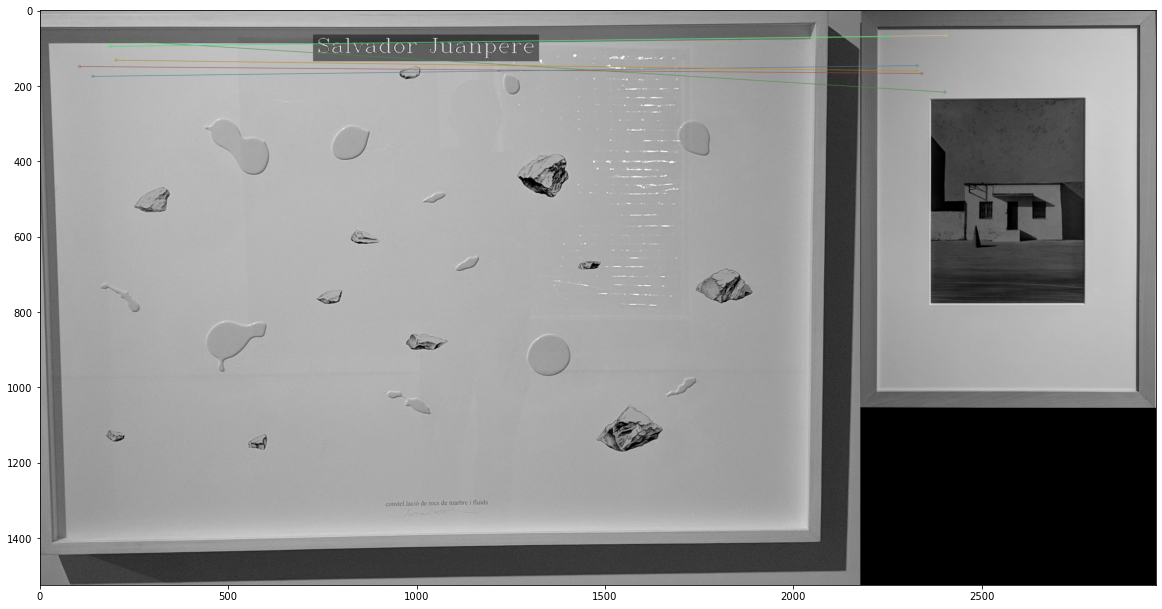

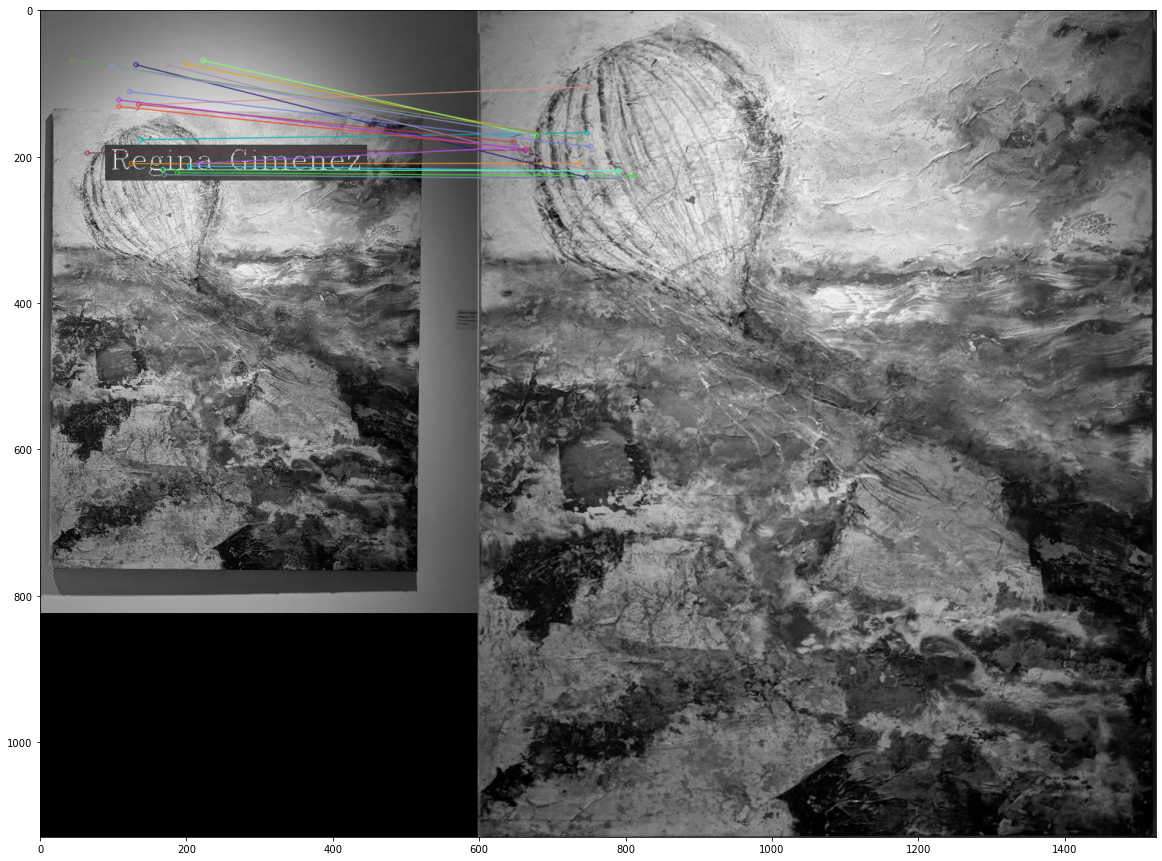

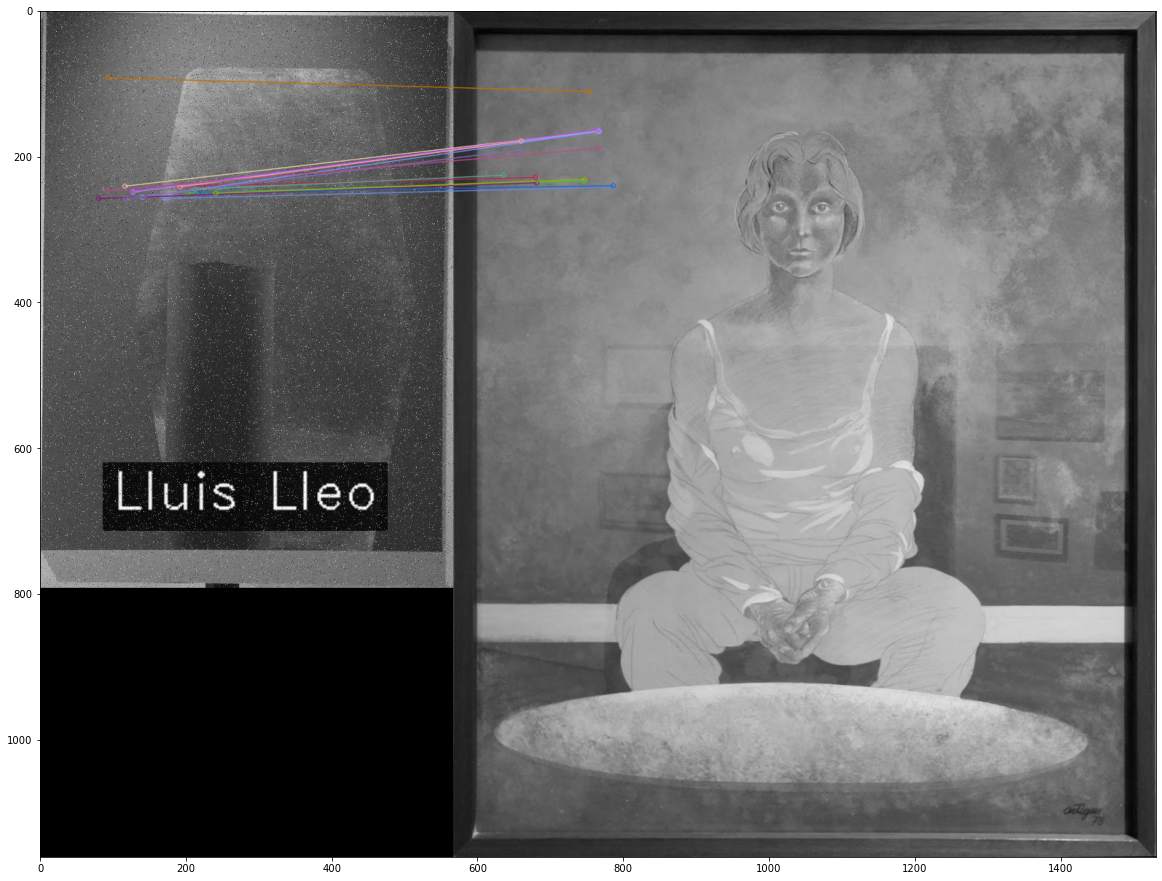

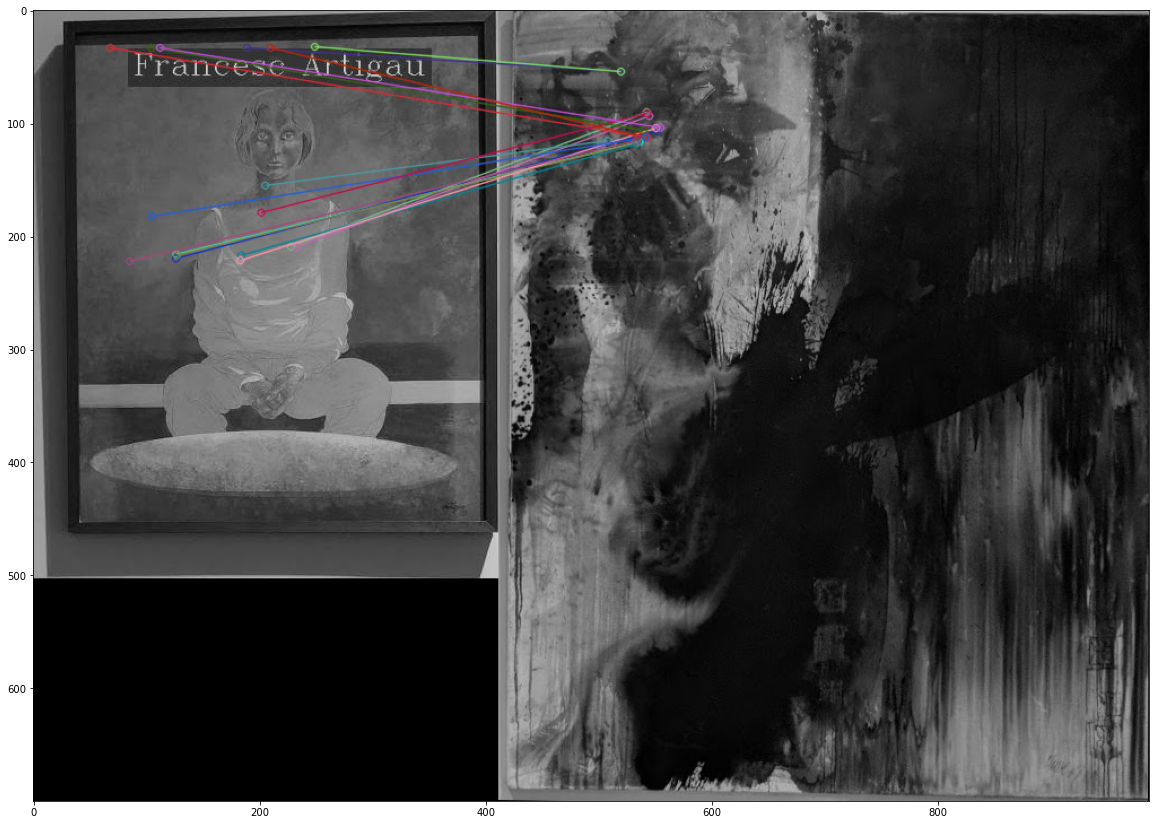

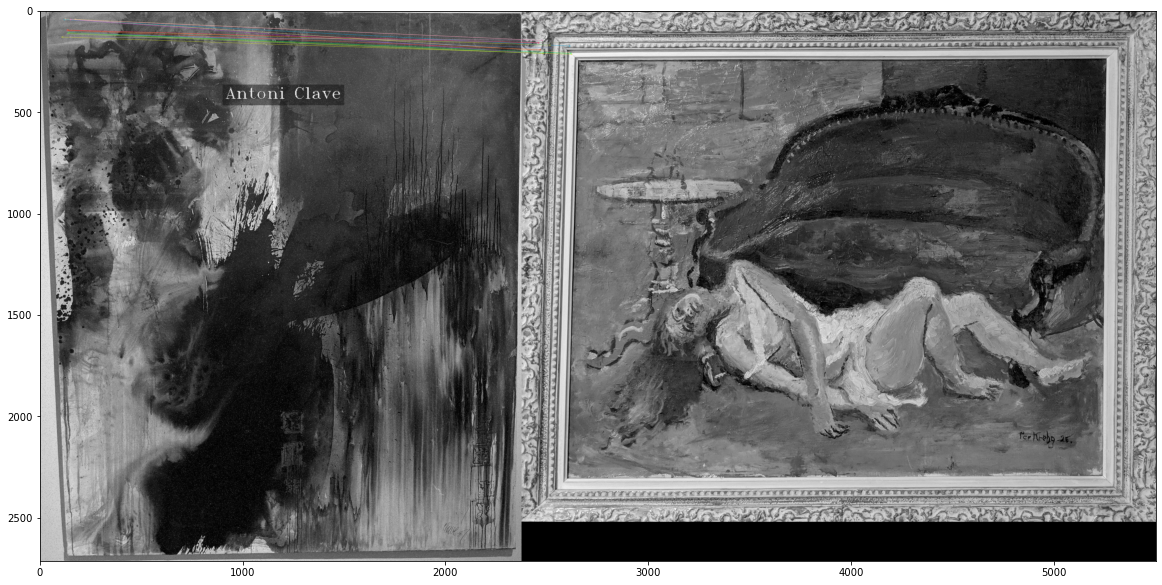

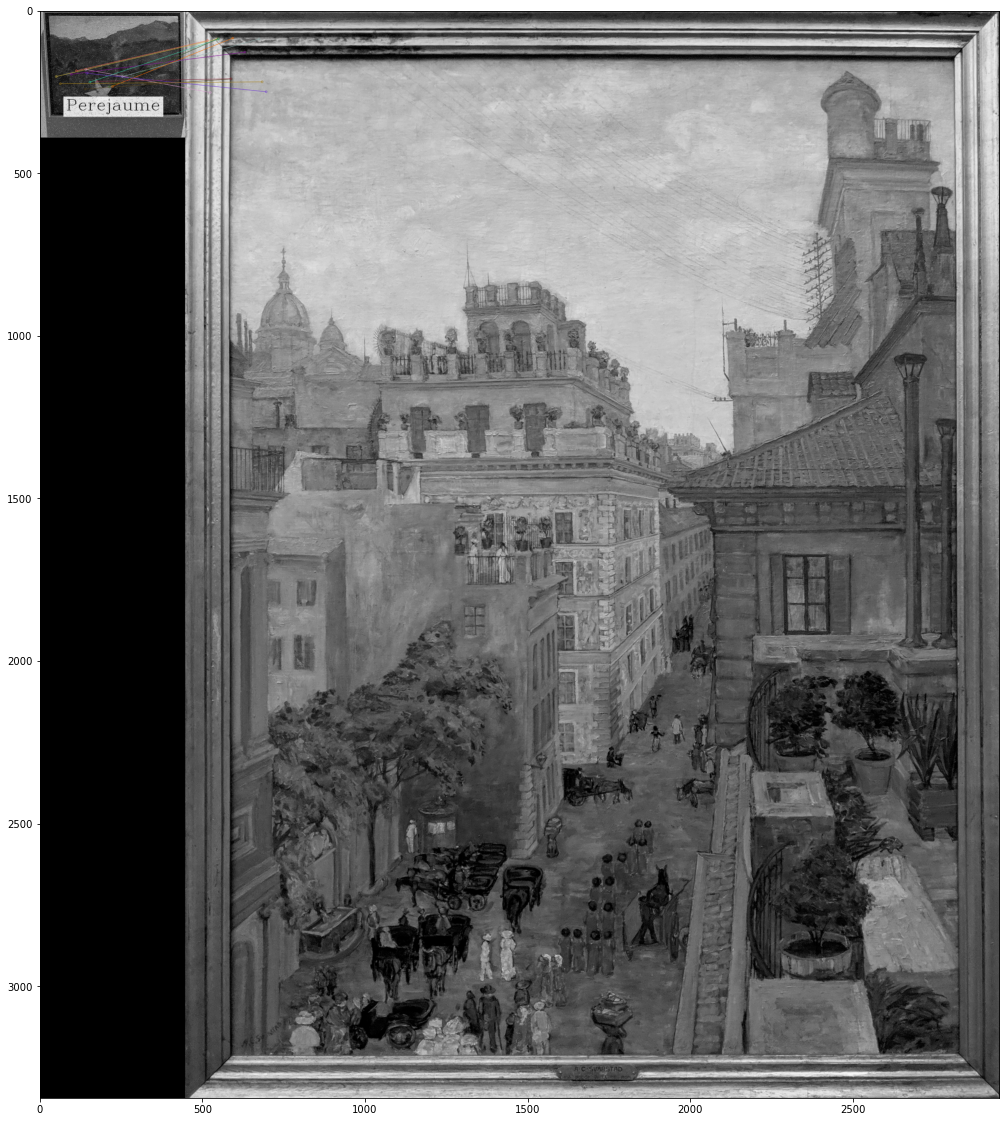

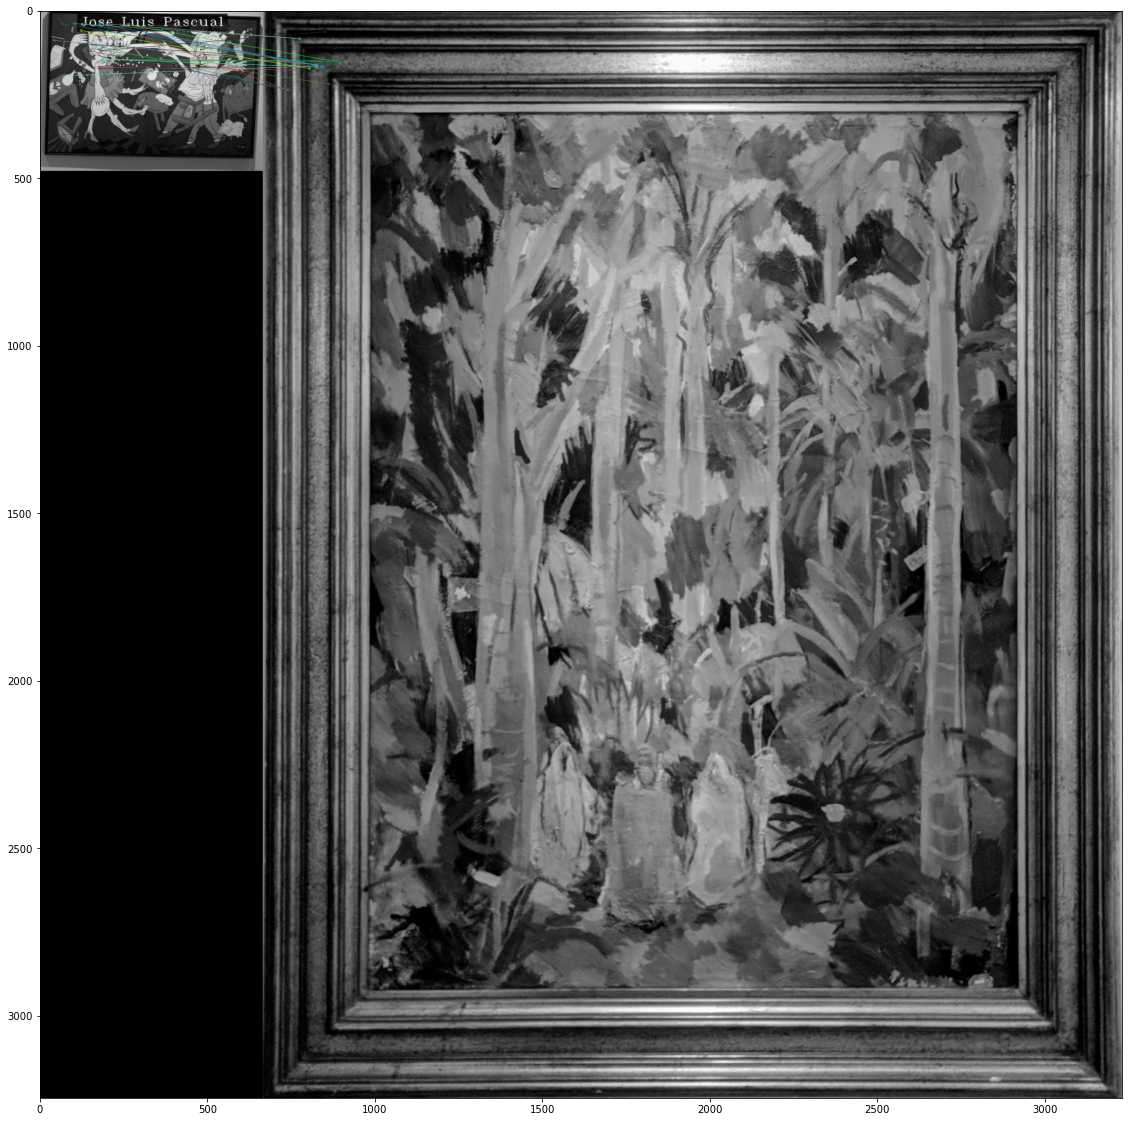

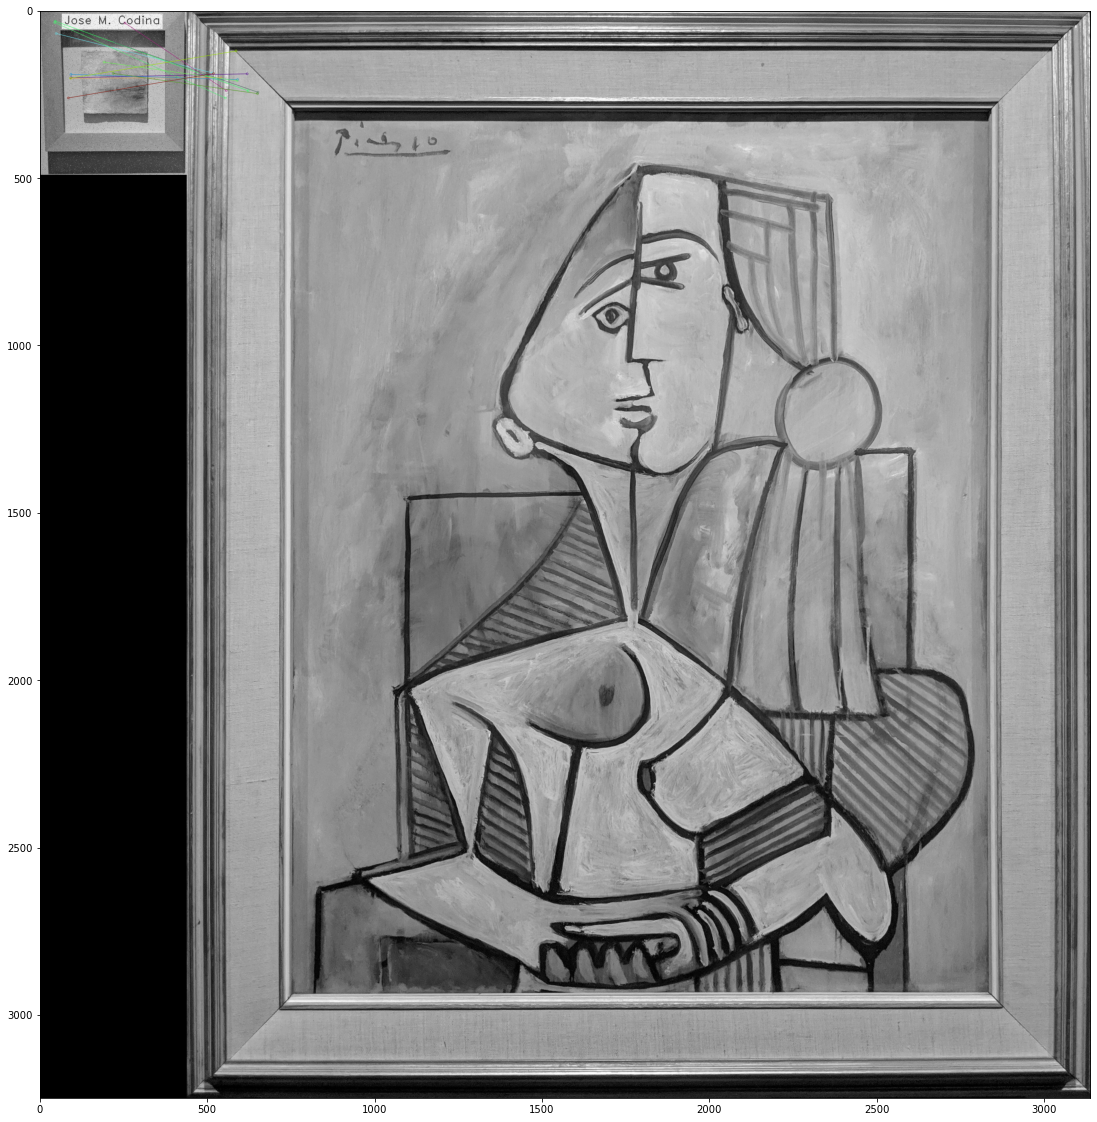

In [38]:
def plot_matches(results, qs, db, kp_qs, desc_qs, kp_db, desc_db):
    for i,idx in enumerate(results):
        idx = idx[0]
        if idx != -1:
            # Query image
            im1 = rgb2gray(qs[i])*255
            im1 = im1.astype(np.uint8)
            kp1, desc1 = kp_qs[i], desc_qs[i]

            # DB image
            im2 = rgb2gray(db[idx])*255
            im2 = im2.astype(np.uint8)
            kp2, desc2 = kp_db[idx], desc_db[idx]

            bf = cv2.BFMatcher_create(cv2.NORM_HAMMING,crossCheck=True)
            matches = bf.match(desc1, desc2)
            matches = sorted(matches,key=lambda x:x.distance)

            im_matches = cv2.drawMatches(im1, kp1, im2, kp2, matches, None, flags=2)
            plt.figure(figsize = (20,20))
            plt.imshow(im_matches)
            plt.show()
            
plot_matches(predicted_results, qsd1_w4, db, keypoints_qsd1_w4_orb, qsd1_w4_local_matrix_orb, keypoints_db_orb, qst1_db_orb)

In [28]:
FIX = False

with open('./week4/QSD1/method1/result.pkl', 'rb') as f:
    data = pickle.load(f)
    
if FIX:
    output = open('./week4/QSD1/method1/result.pkl', 'wb')
    pickle.dump(data, output)
    output.close()

    with open('./week4/QSD1/method1/result.pkl', 'rb') as f:
        data = pickle.load(f)
        data = [list(pred) for pred in data]

RESULTS = {}

# initialize dictionary
for file in qsd1_w4_files:
    RESULTS[file] = []
    
for file, results in zip(qsd1_w4_files,top_k_qs1_w4_local):
    results = [result.replace('./data/BBDD/bbdd_', '').replace('.jpg', '') for result in results]
    results = [int(result) for result in results]
    RESULTS[file].append(results)

# add extra [] to single results
for file in qsd1_w4_files:
    if len(RESULTS[file]) == 1:
        RESULTS[file].append([-1])
    if len(RESULTS[file]) == 2:
        RESULTS[file].append([-1])
        
# final check       
for file in qsd1_w4_files:
    assert len(RESULTS[file]) == 3
    
RESULTS = list(RESULTS.values())

output = open('./week4/QSD1/method1/result.pkl', 'wb')
pickle.dump(RESULTS, output)
output.close()



FIX = False

with open('./week4/QSD1/method1/result.pkl', 'rb') as f:
    data = pickle.load(f)
    
if FIX:
    output = open('./week4/QSD1/method1/result.pkl', 'wb')
    pickle.dump(data, output)
    output.close()

    with open('./week4/QSD1/method1/result.pkl', 'rb') as f:
        data = pickle.load(f)
        data = [list(pred) for pred in data]

AttributeError: 'int' object has no attribute 'replace'

In [ ]:
output = open('./week4/QST1/method1/result.pkl', 'wb')
pickle.dump(data, output)
output.close()